## Exercise 3: Implementing Hyperband for Logistic Regression

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

df = pd.read_csv('Downloads/bank.csv',  delimiter=";") #Read the required csv file and store it
df = pd.get_dummies(df,drop_first = True)  # hot one encoding
df = df.dropna()



From the given data in the question and in the papers provided, I have tried to implement a hyperband for optimising all the hyper parameters and thus producing the optimum accuracy and loss. The hyperparameters taken into consideration are steplength, lambda(regularisation), batch size and step-size controller. They are given specified ranges. The algorithm for hyperband is as follows-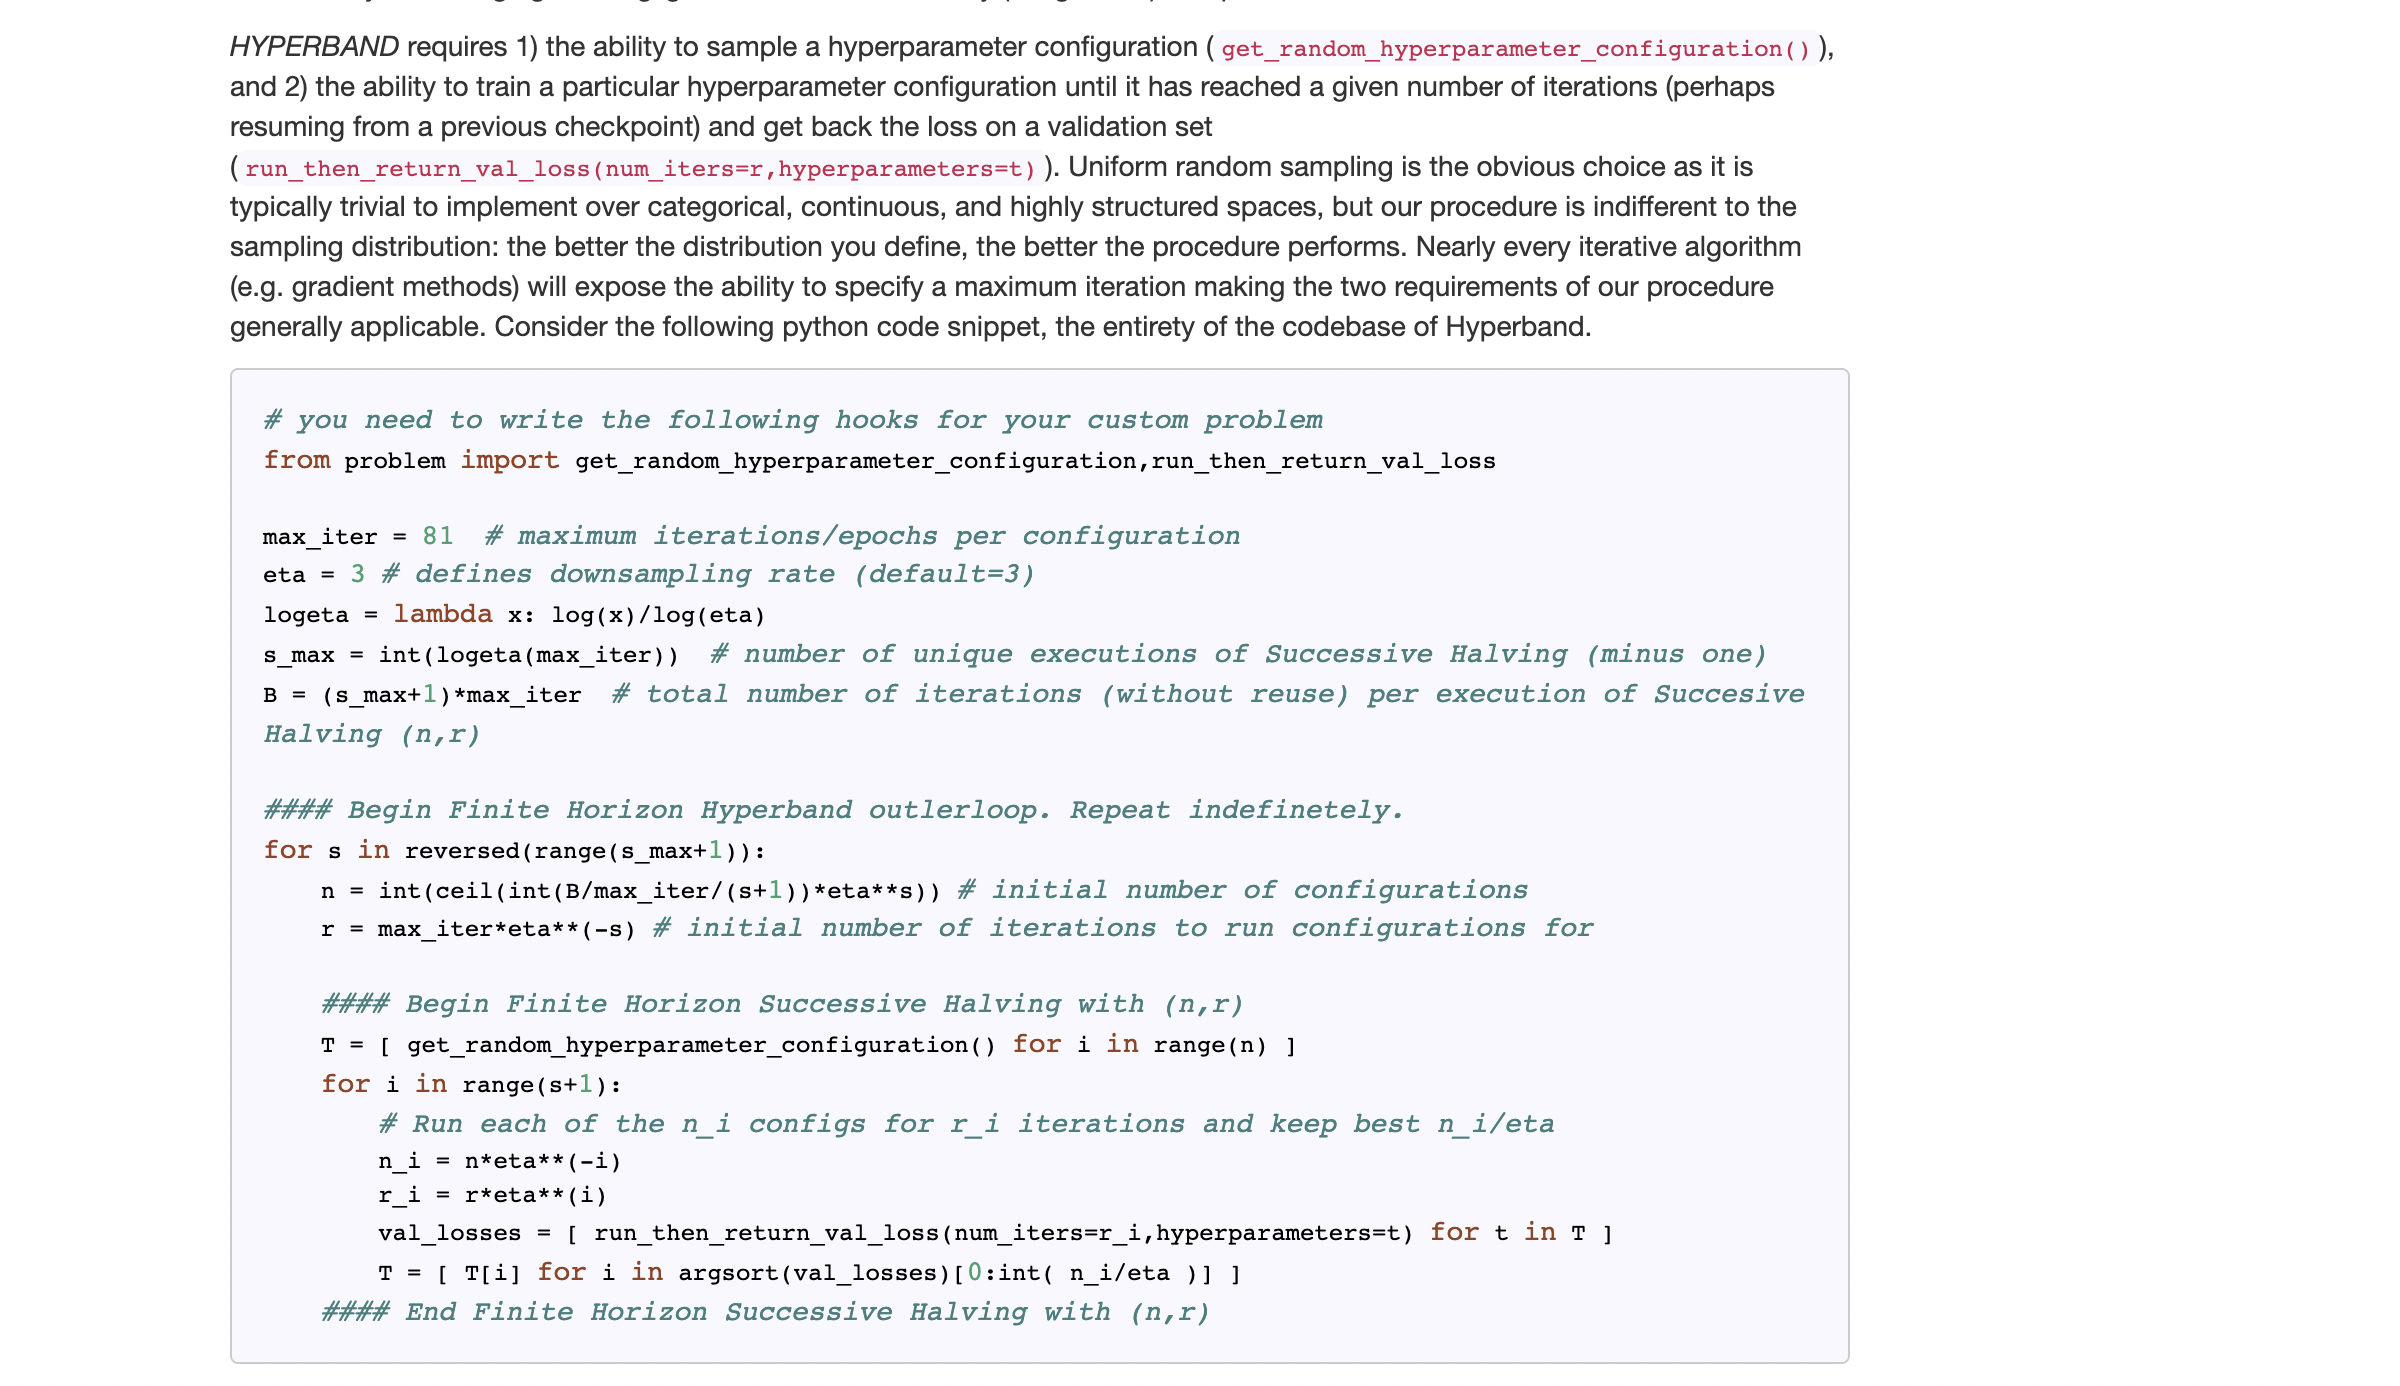


From the above, we need to define a function to get random choices for each hyper parameter. This can be facilitated using the np.random.choice() function. 

In [2]:
def get_random_hyperparameter_configuration():
    mu = random.choice(np.linspace(0.0000000001,0.00001,10))   # Specifing ranges for the hyper parameters
    lamba = random.choice(np.linspace(0.0000000001,0.00001,10))
    batch_size = random.choice(np.arange(30, 100))
    controller =  random.choice(["backtracking","bolddriver"])
    return mu,lamba,batch_size,controller
    
    

We also need to define the logistic regression function which will be used to learn the model and return the accuracy value for each set of hyper parameters. I have reused the logistic regression function from ex02.

In [3]:
#Function to find logloss
def logloss1(y,y_predicted,beta,lamba):
   
    return (y*np.log(y_predicted) + (1-y)*np.log(1-y_predicted)).mean() - (lamba*(beta**2)).sum()


In [4]:
#Bold driver steplength function similar to the one done in earlier lab
def steplength_bolddriver(mu,x,y,beta,lamba):
    
    decay = 0.6
    increase = 1        
    mu = mu * increase 
    #Finding y with x and beta and their logloss
    y_predicted = 1/(1+np.exp(-np.dot(x,beta)))            
           
    log_loss = logloss1(y,y_predicted,beta,lamba)
    
    #Finding new beta and its y and log loss
    beta = beta + mu * ((np.dot(x.T,(y - y_predicted))//len(x)) - (2*lamba*beta) )
    
    y_predicted_new = 1/(1+np.exp(-np.dot(x,beta)))            
           
    log_loss_new = logloss1(y,y_predicted_new,beta,lamba)
    
    while(log_loss < log_loss_new):     # checking current log likelihood and new log likelihood values
        
        mu = mu * decay #changing mu
        beta = beta + mu * ((np.dot(x.T,(y - y_predicted))//len(x)) - (2*lamba*beta) ) #changing beta
    
        y_predicted_new = 1/(1+np.exp(-np.dot(x,beta)))   #calculating new y         
           
        log_loss_new = logloss1(y,y_predicted_new,beta,lamba)#calculating new log loss
    
        
        
        
    return mu

In [5]:
#Backtracking step controller function similar to the one done in earlier lab

def steplength_backtracking(mu,x,y,beta,lamba):
    
    #Calculating y and log loss.
    y_predicted = 1/(1+np.exp(-np.dot(x,beta)))            
           
    log_loss = logloss1(y,y_predicted,beta,lamba)
    
    #Finding new beta, y_predicted and log loss
    beta = beta + mu * ((np.dot(x.T,(y - y_predicted))//len(x)) - (2*lamba*beta) )
    
    y_predicted_new = 1/(1+np.exp(-np.dot(x,beta)))            
           
    log_loss_new = logloss1(y,y_predicted_new,beta,lamba)
    
    #taking square of the gradient to form the bound in the condition
    sq_gradient = np.dot(((np.dot(x.T,(y - y_predicted))//len(x)) - (2*lamba*beta)).T,((np.dot(x.T,(y - y_predicted))//len(x)) - (2*lamba*beta)))
    RHS = log_loss - (mu*0.1*sq_gradient) 
    while (log_loss_new > RHS): #checking the condition
        mu = mu*0.1 #taking alpha as 0.1
        
        # calculating new beta, y and log loss
        beta = beta + mu * ((np.dot(x.T,(y - y_predicted))//len(x)) - (2*lamba*beta) )
        y_predicted_new = 1/(1+np.exp(-np.dot(x,beta)))
        log_loss_new = logloss1(y,y_predicted_new,beta,lamba)
        
    return mu

Function to implement logistic regression using gradient ascent (mini-batch) is same as one used in ex02

In [6]:

def logReg_miniGA(x_train,y_train,x_test,y_test,mu,lamba,controller,batch_size,imax):
    
    beta = np.zeros(x_train.shape[1]).reshape(-1,1) #Initialize beta
    log_list_train = []
    log_list_test = []
    check_list = []
    max_check = 0
    
    for i in range(imax): #for each epoch
        pdt = np.dot(x_train,beta)
        log = np.sum(np.dot(y_train.T,pdt)-np.log(1+ (np.exp(pdt)))) # Eqn of log likelikhood taken from algorithm
        
        #Finding initial y value 
        y_hat_prev = 1/(1+np.exp(-np.dot(x_train,beta)))

        for j in range((len(x_train)//batch_size)):    #Loop for iterating through each batch of x for mini batch gradient ascent
            
            x_batch = x_train[j*batch_size:min((j+1)*batch_size,len(x_train))]
            y_batch = y_train[j*batch_size:min((j+1)*batch_size,len(y_train))]
            
            y_predicted = 1/(1+np.exp(-np.dot(x_batch,beta)))    #predicting y for one batch of x
            
            if(controller == "boldriver"):
                mu = steplength_bolddriver(mu,x_batch,y_batch,beta,lamba)
            elif(controller == "backtrackiing"):
                mu = steplength_backtracking(mu,x_batch,y_batch,beta,lamba)
            
            #Calculating new beta ,y , loss and accuracy values
            beta = beta + mu * ((np.dot(x_batch.T,(y_batch - y_predicted))//len(x_batch)) - (2*lamba*beta) )
            
            y_predicted = 1/(1+np.exp(-np.dot(x_batch,beta)))
            
            
            
            log_loss = logloss1(y_batch,y_predicted,beta,lamba)
            log_list_train.append(-log_loss)
            
            y_predicted_test = 1/(1+np.exp(-np.dot(x_test,beta)))
            
            log_loss_test = -logloss1(y_test,y_predicted_test,beta,lamba)
            log_list_test.append(log_loss_test)
            
            classification = (y_predicted_test>0.5)
            classification= classification.astype('int')
            check = (classification == y_test).mean()
            check_list.append(check)
            
           
            
       #Implementing the same functions for the remainder elements in the batch      
        if((len(x_train)%batch_size)>0):
            x_batch = x_train[len(x_train)//batch_size*batch_size:,] #yo
            y_batch = y_train[len(y_train)//batch_size*batch_size:,]
            
            y_predicted = 1/(1+np.exp(-np.dot(x_batch,beta)))    #predicting y for one batch of x
            
            if(controller == "boldriver"):
                mu = steplength_bolddriver(mu,x_batch,y_batch,beta,lamba)
            elif(controller == "backtrackiing"):
                mu = steplength_backtracking(mu,x_batch,y_batch,beta,lamba)
                
            beta = beta + mu * ((np.dot(x_batch.T,(y_batch - y_predicted))//len(x_batch)) - (2*lamba*beta) )
            
            y_predicted = 1/(1+np.exp(-np.dot(x_batch,beta)))
            #print(y_batch.shape,y_predicted.shape)
            log_loss = -logloss1(y_batch,y_predicted,beta,lamba)
            log_list_train.append(log_loss)
            
            y_predicted_test = 1/(1+np.exp(-np.dot(x_test,beta)))
            
            log_loss_test = -logloss1(y_test,y_predicted_test,beta,lamba)
            log_list_test.append(log_loss_test)
            
            classification = (y_predicted_test>0.5)
            classification= classification.astype('int')
            check = (classification == y_test).mean()
            check_list.append(check)
            
           #Returning the minimum of the losses and maximum of the accuracy values obtained by the learning process
    return min(log_list_train),min(log_list_test),max(check_list)
            
            

Splitting the data set into train, validation and test data sets in the ratio (70:15:15) as given in the question

In [7]:

#Finding the train set
df_train = df.groupby('y_yes', group_keys=False).apply(lambda x: x.sample(frac=0.7, random_state = 3116))
train_index = df_train.index
df_rest = df.drop(train_index) #dropping the training data to get test data and validation data

#Finding the validation set from the rest of the set
df_val = df_rest.groupby('y_yes', group_keys=False).apply(lambda x: x.sample(frac=0.5, random_state = 3116))
val_index = df_val.index
df_test = df_rest.drop(val_index)#dropping the validation data to get test data

df_val

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,y_yes
2605,48,247,14,145,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
291,47,480,28,211,2,-1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
784,27,5,19,205,3,-1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4516,33,-333,30,329,5,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4174,42,10907,4,74,3,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,29,908,20,1663,1,-1,0,1,0,0,...,1,0,0,0,0,0,0,0,1,1
3256,36,495,12,213,3,182,6,0,0,0,...,0,1,0,0,0,0,0,1,0,1
4256,34,2929,14,518,2,-1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
2375,26,622,28,1451,2,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [8]:
# putting the target feature to y array 
y_train = np.array(df_train[['y_yes']])
x_train = np.array(df_train.drop(['y_yes'],axis =1))

mean = x_train.mean()    #Normalization
sd = x_train.std()

x_train = (x_train - mean)/sd

y_test = np.array(df_test[['y_yes']])
x_test = np.array(df_test.drop(['y_yes'],axis =1))
x_test = (x_test - mean)/sd

y_val = np.array(df_val[['y_yes']])
x_val = np.array(df_val.drop(['y_yes'],axis =1))
x_val = (x_val - mean)/sd





print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
print(x_val.shape,y_val.shape)

(3165, 42) (3165, 1)
(678, 42) (678, 1)
(678, 42) (678, 1)


Function to implement hyperband for logistic regression according to the given algorithm

In [9]:
def hyperband():
    max_iter = 81  # maximum iterations/epochs per configuration as given in algorithm
    eta = 3 # defines downsampling rate (default=3) as given in algorithm
    logeta = lambda x: np.log(x)/np.log(eta)
    s_max = int(logeta(max_iter))  # number of unique executions of Successive Halving (minus one)
    B = (s_max+1)*max_iter  # total number of iterations (without reuse) per execution of Succesive Halving (n,r)

    #### Begin Finite Horizon Hyperband outlerloop. Repeat indefinetely.
    for s in reversed(range(s_max+1)):
        n = int(np.ceil(int(B/max_iter/(s+1))*eta**s)) # initial number of configurations
        r = max_iter*eta**(-s) # initial number of iterations to run configurations for

        #### Begin Finite Horizon Successive Halving with (n,r)
        T = [ get_random_hyperparameter_configuration() for i in range(n) ]  # obtaining a random set of hyperparameters
        for i in range(s+1):
            # Run each of the n_i configs for r_i iterations and keep best n_i/eta
            n_i = n*eta**(-i)
            r_i =int( r*eta**(i)) # finding and converting imax to int

            # Calling the regression funvtion for a set of hyper parameters and storing the accuracy value
            val_losses = [ logReg_miniGA(x_train,y_train,x_test,y_test,mu=t[-4],lamba=t[-3],controller =t[-1],batch_size=t[-2],imax=r_i)[2]for t in T]  
            T = [ T[i] for i in np.argsort(val_losses)[0:int( n_i/eta )] ] # Finding the combination with maximum accuracy value
        #### End Finite Horizon Successive Halving with (n,r)

    return(T)

In [10]:

acc = hyperband() # Calling hyperband to return the optimum hyper parameter combination
print("The optimum steplength,lambda,batchsize and controller are -", acc[0])

The optimum steplength,lambda,batchsize and controller are - (3.3333999999999997e-06, 8.8889e-06, 43, 'bolddriver')


In [15]:
optimum_params = acc[0]

log_loss1_b,log_loss_b,accuracy_b = logReg_miniGA(x_val,y_val,x_test,y_test,mu=1,lamba=1,controller ='backtracking1',batch_size=50,imax=83)
#Now training the model with the optimum hyper parameters
log_loss1,log_loss,accuracy = logReg_miniGA(x_val,y_val,x_test,y_test,mu=optimum_params[0],lamba=optimum_params[1],controller ='backtracking1',batch_size=optimum_params[2],imax=83)

print("Accuracy before training with optimum parameters-",accuracy_b)
print("Log loss before training with optimum parameters-",log_loss_b)
print("Accuracy after training with optimum parameters-",accuracy)
print("Log loss after training with optimum parameters-",log_loss)


<ipython-input-3-5543aa4dda07>:4: RuntimeWarning: divide by zero encountered in log
  return (y*np.log(y_predicted) + (1-y)*np.log(1-y_predicted)).mean() - (lamba*(beta**2)).sum()
<ipython-input-3-5543aa4dda07>:4: RuntimeWarning: invalid value encountered in multiply
  return (y*np.log(y_predicted) + (1-y)*np.log(1-y_predicted)).mean() - (lamba*(beta**2)).sum()
<ipython-input-6-3b1ad4695a1a>:38: RuntimeWarning: overflow encountered in exp
  y_predicted_test = 1/(1+np.exp(-np.dot(x_test,beta)))
<ipython-input-6-3b1ad4695a1a>:21: RuntimeWarning: overflow encountered in exp
  y_predicted = 1/(1+np.exp(-np.dot(x_batch,beta)))    #predicting y for one batch of x
<ipython-input-6-3b1ad4695a1a>:11: RuntimeWarning: overflow encountered in exp
  log = np.sum(np.dot(y_train.T,pdt)-np.log(1+ (np.exp(pdt)))) # Eqn of log likelikhood taken from algorithm
<ipython-input-6-3b1ad4695a1a>:31: RuntimeWarning: overflow encountered in exp
  y_predicted = 1/(1+np.exp(-np.dot(x_batch,beta)))
<ipython-input-

Accuracy before training with optimum parameters- 0.7743362831858407
Log loss before training with optimum parameters- 6.300073746753835
Accuracy after training with optimum parameters- 0.7861356932153393
Log loss after training with optimum parameters- 0.6866203469346371


We observe that accuracy has increased and log loss has decreased.

### References

https://homes.cs.washington.edu/~jamieson/hyperband.html
https://www.codegrepper.com/code-examples/python/how+to+get+a+random+element+from+an+array+in+python


https://medium.com/@lily_su/logistic-regression-accuracy-cross-validation-58d9eb58d6e6
https://numpy.org/doc/stable/reference/generated/numpy.linspace.html
https://www.statology.org/aic-in-python/
https://stackoverflow.com/questions/10996140/how-to-remove-specific-elements-in-a-numpy-array
https://www.ismll.uni-hildesheim.de/lehre/ml-20w/script/index.html
https://github.com/iamkucuk/Logistic-Regression-With-Mini-Batch-Gradient-Descent/blob/master/logistic_regression_notebook.ipynb
https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
https://thispointer.com/find-max-value-its-index-in-numpy-array-numpy-amax/